In [290]:
import pandas as pd
import datetime as dt

In [294]:
df = pd.read_csv('DesMoines_GDD_PredictedGDD.csv')
from datetime import datetime
import time
def convert_date_string(date_str):
    time_struct = time.strptime(date_str, '%m/%d/%y')
    dt_obj = datetime(*time_struct[:6])
    new_date_str = dt_obj.strftime('%m/%d/%y')
    return new_date_str
df['Date'] = df['Date'].apply(lambda x: convert_date_string(x))
corn = pd.read_excel('commodity_prices.xlsx', sheet_name='C 1 (Corn)')[['Date','Last Price']]
corn.rename(columns={'Last Price':'Corn'}, inplace=True)
def converter(s):
    parts = s.split()
    integer_part = int(parts[0])
    fraction_part = eval(parts[1])
    result = integer_part + fraction_part
    return result
corn['Corn'] = corn['Corn'].apply(lambda x: converter(x) if ' ' in str(x) else x)
corn['Date'] = corn['Date'].apply(lambda x: str(x))
def convert_date_string(date_str):
    dt_obj = dt.datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')
    new_date_str = dt_obj.strftime('%m/%d/%y')
    return new_date_str
corn['Date'] = corn['Date'].apply(lambda x: convert_date_string(x))
df = pd.merge(df, corn, on='Date', how='inner')

In [295]:
df['Corn_returns'] = df['Corn'].pct_change()
df['Corn_cumulative_returns'] = (1 + df['Corn_returns']).cumprod()
def trader(MA_window,stds,corr_window,corr_threshold,df=df):
    df['Predicted_GDD_MA'] = df['Predicted GDD'].rolling(MA_window).mean()
    df['upper'] = df['Predicted_GDD_MA'] + stds * df['Predicted GDD'].rolling(MA_window).std()
    df['lower'] = df['Predicted_GDD_MA'] - stds * df['Predicted GDD'].rolling(MA_window).std()
    df['correlation'] = df['Corn_returns'].rolling(corr_window).corr(df['Predicted GDD'])
    df['signal'] = 0
    df.loc[df['Predicted GDD'] > df['upper'], 'signal'] = -1
    df.loc[df['Predicted GDD'] < df['lower'], 'signal'] = 1
    df.loc[df['correlation'] < corr_threshold, 'signal'] = 0
    df['signal'] = df['signal'].shift(1)
    df['signal returns'] = df['signal'] * df['Corn_returns']
    df['signal cumulative returns'] = (1 + df['signal returns']).cumprod()  
    return df[['Corn_cumulative_returns', 'signal cumulative returns']].plot()
    #return list(df['signal cumulative returns'])[-1]

In [238]:
MAs = [5,10,15,20,25,30,35,40,45,50]
stds = [.1,.25,.5,.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3]
corr_windows = [5,10,15,20,25,30,35,40,45,50]
corr_thresholds = [-.5,-.25,-.1,0,.1,.25,.5,.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3]

In [234]:
# try every combination of parameters to return the best combination
best = 0
for MA in MAs:
    for std in stds:
        for corr_window in corr_windows:
            for corr_threshold in corr_thresholds:
                result = trader(MA,std,corr_window,corr_threshold)
                if result > best:
                    best = result
                    best_params = [MA,std,corr_window,corr_threshold]

In [240]:
best_params

[50, 0.1, 15, -0.5]

<AxesSubplot: >

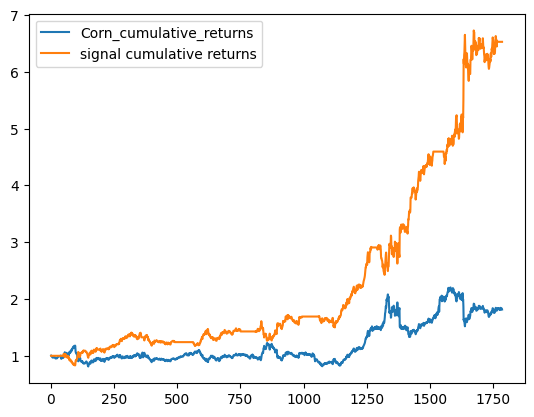

In [296]:
trader(MA_window=50,stds=.1,corr_window=15,corr_threshold=-0.5)